# EE4375-2022: Fourth Lab Session: Mesh Generation of Channel  

Gives an examples on geometry definition and mesh generation using GMSH followed by PDE solve using Gridap.   

## Import Packages

In [51]:
using Gmsh
using GR 
using LinearAlgebra
#using Plots
using LaTeXStrings
using SparseArrays
#using GLMakie

using Gridap
using GridapGmsh
using Gridap.Algebra;
using Gridap.FESpaces
using Gridap.ReferenceFEs
using Gridap.Arrays
using Gridap.Geometry
using Gridap.Fields
using Gridap.CellData

using CairoMakie
using GeometryBasics
CairoMakie.activate!(type = "svg")

using WriteVTK # post processing 

using BenchmarkTools 

## Section 1/: Geometry Definition and Mesh Generation for Rectangular Channel Geometry 

Mesh generation for rectangular geometry. 

<b>Exercise</b>: Extend to uniform meshes. See GMSH Transfinite Mesh generation for more uniform meshes at [GMSH Transfinite Mesh Tutorial](https://gmsh.info/doc/texinfo/gmsh.html#t6).

In [58]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
# add name to the model 
gmsh.model.add("channel")
# set parameter that controls the density of the mesh on the four points of the geometry 
lc = 5e-2
# add four points with zero z-coordinate and with labels 1 through 4 
# point is formed by 3 coordinates 
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(3., 0,  0, lc, 2)
gmsh.model.geo.addPoint(3., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
# add four lines with labels 5 through 8 
# line is formed by 2 points 
gmsh.model.geo.addLine(1, 2, 5)
gmsh.model.geo.addLine(2, 3, 6)
gmsh.model.geo.addLine(3, 4, 7)
gmsh.model.geo.addLine(4, 1, 8)
# add curve with label 9
# curve is formed by 4 lines 
gmsh.model.geo.addCurveLoop([5, 6, 7, 8], 9)
# add surface with label 10 
# surface is formed by single curve 
gmsh.model.geo.addPlaneSurface([9], 10)
gmsh.model.geo.addPhysicalGroup(2, [10], 11)  # Create 2d physical domain (tag = 11) from surface 10
gmsh.model.setPhysicalName(2, 10, "My surface")
tag_left = [8]; tag_right = [6]; 

#gmsh.model.geo.addPhysicalGroup(dim, tags, tag) # Physical group with tag ‘tag’ containing elements of dimension ‘dim’ and tags ‘tags’
#gmsh.model.setPhysicalName(dim, tag, name)       # Sets the name of physical group ‘tag’ and dimension ‘dim’ to ‘name’
gmsh.model.geo.addPhysicalGroup(1, tag_left, 11)
gmsh.model.setPhysicalName(1, 11, "bnd_left") # Left boundary
gmsh.model.geo.addPhysicalGroup(1, tag_right, 12)
gmsh.model.setPhysicalName(1, 12, "bnd_right") # Right boundary

gmsh.model.geo.synchronize()
# generate the mesh 
#gmsh.model.mesh.algorithm = 8; # Delaunay for quads
gmsh.model.mesh.generate(2)

#..Extract the nodes from the mesh 
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]
xnode = node_coord[1:3:end]
ynode = node_coord[2:3:end]

gmsh.write("channel.msh")
gmsh.finalize()

println("  number of nodes = ", nnodes)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000545542s, CPU 0.000472s)
Info    : Meshing 2D...
Info    : Meshing surface 10 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0439058s, CPU 0.040419s)
Info    : 1475 nodes 2952 elements
Info    : Writing 'channel.msh'...
Info    : Done writing 'channel.msh'
  number of nodes = 1475


### Section 1.2:/ Transfinite Meshing

In [ ]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
# add name to the model 
gmsh.model.add("channel")
# set parameter that controls the density of the mesh on the four points of the geometry 
lc = 5e-2
# add four points with zero z-coordinate and with labels 1 through 4 
# point is formed by 3 coordinates 
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(3., 0,  0, lc, 2)
gmsh.model.geo.addPoint(3., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
# add four lines with labels 5 through 8 
# line is formed by 2 points 
gmsh.model.geo.addLine(1, 2, 5)
gmsh.model.geo.addLine(2, 3, 6)
gmsh.model.geo.addLine(3, 4, 7)
gmsh.model.geo.addLine(4, 1, 8)
# add curve with label 9
# curve is formed by 4 lines 
gmsh.model.geo.addCurveLoop([5, 6, 7, 8], 9)
# add surface with label 10 
# surface is formed by single curve 
gmsh.model.geo.addPlaneSurface([9], 10)
gmsh.model.geo.addPhysicalGroup(2, [10], 11)  # Create 2d physical domain (tag = 11) from surface 10
gmsh.model.setPhysicalName(2, 10, "My surface")

gmsh.model.geo.synchronize()
# generate the mesh 
#gmsh.model.mesh.algorithm = 8; # Delaunay for quads
gmsh.model.mesh.generate(2)

gmsh.write("channel.msh")
gmsh.finalize()

## Section 2/: Visualize the Mesh 

In [28]:
# Obtain a GeometryBasics.Mesh object suitable for plotting with Makie
# Contributed by Gijs Lagerweij 
function get_node_mesh()
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nNode = length(node_ids)

    eType, eTag, eConn = gmsh.model.mesh.getElements(2);
    nEl = length(eTag[1])

    points   = zeros(Point2f, nNode);          # Array of vertex coordinates (x,y)
    trif     = zeros(TriangleFace{Int}, nEl);  # Array of triangular faces (n1, n2, n3)
    
    for n in 1:nNode
        points[node_ids[n]] = Point2f(node_coord[3*(n-1) + 1], node_coord[3*(n-1) + 2])
    end
    for e in 1:nEl
        trif[e] = (eConn[1][3*(e-1)+1], eConn[1][3*(e-1)+2], eConn[1][3*(e-1)+3])
    end
    
    msh = GeometryBasics.Mesh(points, trif);
    return msh;
end

get_node_mesh (generic function with 1 method)

Info    : Reading 'channel.msh'...
Info    : 9 entities
Info    : 1475 nodes
Info    : 2828 elements
Info    : Done reading 'channel.msh'


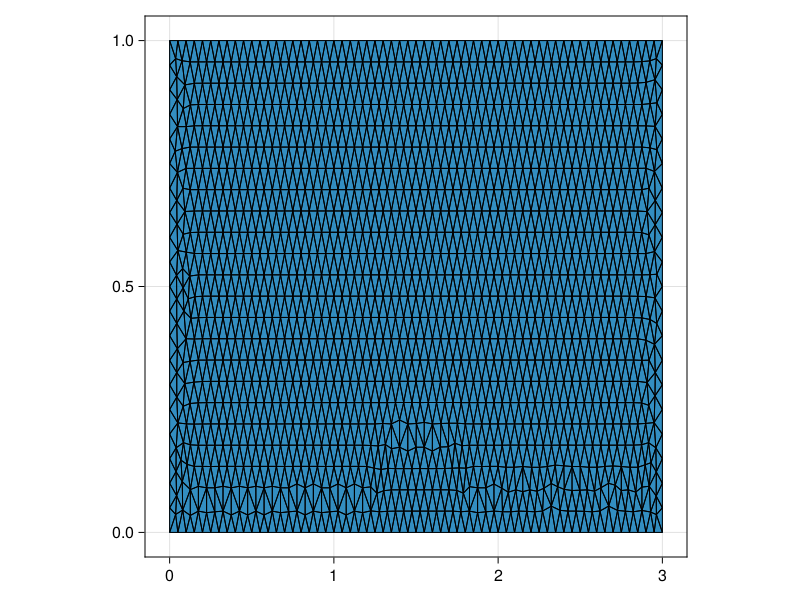

In [40]:
gmsh.initialize()
gmsh.open("channel.msh")
mshdata = get_mesh_data();

msh = get_node_mesh()

f, ax, pl = mesh(msh, shading = false)
wireframe!(ax, msh, color=(:black), linewidth=1, transparency=false)
ax.aspect = AxisAspect(1)
current_figure()

## Section 3/: FE Assembly and Solve 

In [29]:
# Load mesh
model = GmshDiscreteModel("channel.msh")
#Ω = Triangulation(model)

Info    : Reading 'channel.msh'...
Info    : 9 entities
Info    : 1475 nodes
Info    : 2828 elements
Info    : Done reading 'channel.msh'


UnstructuredDiscreteModel()

In [30]:
# Define Lagrangian reference element
order = 1
reffe = ReferenceFE(lagrangian,Float64,order)
Vh = FESpace(model, reffe; conformity=:H1, dirichlet_tags = ["bnd_left", "bnd_right"])
Uh = TrialFESpace(Vh, [0, 1]) # Left boundary: u = 0, right boundary: u = 1

TrialFESpace()

In [31]:
degree = 2
Ω = Triangulation(model)
dΩ = Measure(Ω,degree)

Measure()

In [34]:
ff(x) = 1.0
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
b(v) = ∫( v*ff )*dΩ

b (generic function with 1 method)

In [35]:
op = AffineFEOperator(a,b,Uh,Vh)

AffineFEOperator()

In [36]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [37]:
uh = solve(solver,op)

SingleFieldFEFunction():
 num_cells: 2788
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 14487810350196559622

In [38]:
writevtk(Ω,"results",cellfields=["uh"=>uh])

(["results.vtu"],)

In [ ]:
writevtk(Ω, "images/transformer_gridap/transformer1", cellfields=["Az"=>abs(uh)

## Section 4:/ Visualize Computed Solution 

In [39]:
# mesh_data struct
#  saves the nodes and elements of a gmsh geometry, for easy passing around in functions
struct mesh_data
    nnodes  # number of nodes
    xnode   # array of x coordinates
    ynode   # array of y coordinates
    
    nelements   # number of elements
    #element_connectivity  # array of connectivity for each element
    e_group     # array containing the physical group number of each element
    elements    #  more conveniently structured connectivity array
end

# Loads nodes, elements, and element physical groups from gmsh and stores them in a mesh_data struct
function get_mesh_data()
    #..2/11 Get and sort the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]
    
    #..4/12 Get the mesh elements
    #..observe that we get all the two-dimensional triangular elements from the mesh
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelements = length(element_ids[1])

    #..5/12 Create groups of elements for the subdomains
    #..for loop that creates a vector describing which physical group an element belongs to
    ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 1)
    e_group = zeros(1,nelements)
    
    elements = [zeros(Int, 3) for i in 1:nelements];
    
    for element_id in 1:nelements
        node1_id = element_connectivity[1][3*(element_id-1)+1]
        node2_id = element_connectivity[1][3*(element_id-1)+2]
        node3_id = element_connectivity[1][3*(element_id-1)+3]
        
        # Store connectivity in a convenient format
        elements[element_id] = [node1_id, node2_id, node3_id];
        
        # Determine which physical group the element belongs to
        G1  = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) # Oil
        
        if G1 == 3
            e_group[element_id] = 1;
        end 
    end
    
    return mesh_data(nnodes, xnode, ynode, nelements, e_group, elements)
end

get_mesh_data (generic function with 1 method)

In [54]:
typeof(uh);
Gridap.CellData.get_data(uh);
evaluate(uh,[Gridap.Geometry.Point(0.5,0.5)])

1-element Vector{Float64}:
 0.7944257323806816

In [55]:
# Define nodes (points) and elements (cells)
points = [mshdata.xnode mshdata.ynode]';
cells = [MeshCell(VTKCellTypes.VTK_TRIANGLE, el) for el in mshdata.elements];

# Create VTK file structure using nodes and elements
vtkfile = vtk_grid("channel1.vtu", points, cells);

# Store data in the VTK file
vtkfile["uh", VTKPointData()] = uhevaluated;

# Save the file
outfiles = vtk_save(vtkfile);

LoadError: MethodError: no method matching length(::Type{Vector{Float64}})
[0mClosest candidates are:
[0m  length([91m::Union{Base.KeySet, Base.ValueIterator}[39m) at abstractdict.jl:58
[0m  length([91m::Union{ZMQ._Message, Base.RefValue{ZMQ._Message}}[39m) at ~/.julia/packages/ZMQ/lrABE/src/_message.jl:31
[0m  length([91m::Union{JLD2.Group, JLD2.JLDFile}[39m) at ~/.julia/packages/JLD2/HnW0g/src/JLD2.jl:457
[0m  ...